## Machine Learning using cuML and cuDF

Original Author: Jay Rodge

This notebook introduces how to use cuML and cuDF to build Machine Learning models.


cuML is a suite of fast, GPU-accelerated machine learning algorithms designed for data science and analytical tasks. The API mirrors Sklearn’s, and provides practitioners with the easy fit-predict-transform paradigm without ever having to program on a GPU.

cuDF is a GPU DataFrame library for loading, joining, aggregating, filtering, and otherwise manipulating data in time series datasets, especially large ones. It provides a pandas-like API, so users can readily speed up their workflow by ~800x, by changing pandas.DataFrame() to cudf.DataFrame(). You may explore the latest [cuDF API](https://docs.rapids.ai/api/cudf/nightly/api_docs/index.html).

The table shows the performance speed-up, comparing cuDF vs Pandas on an RTX 8000 GPU with an Intel® Core™ i7-7800X CPU @ 3.50GHz × 12 .(Details at the end.)

**<p style="text-align: center;">Performance Results based on test results</p>**


|function| GPU Time | CPU Time| GPU Speedup |
| --- | --- | --- | --- |   
|Classification|30.2|1323.8|43.83|    
|Regression|2.99|73.64|24.62|    
|Clustering|3.1|60.72|19.58|    


**Note**: This resource serves as an introduction to machine learning with cuML, demonstrating common algorithms for learning purposes. It's not intended as a definitive guide for feature engineering or model building. Each ML scenario is unique and might require custom techniques. Always consider your problem specifics when building ML models.

The [MeteoNet Dataset](https://www.kaggle.com/datasets/katerpillar/meteonet) is downloaded and analyzed in this notebook to provide a practical example to data scientists.

We'll download the dataset for you in this notebook, but it can be manually downloaded from https://meteonet.umr-cnrm.fr/dataset/data/ .

### Environment for RAPIDS
You can install one of below environments for RAPIDS. Referring to [Step 2: Install Environment](https://rapids.ai/start.html), the possible environments are:
* PIP installation
* Conda
* Build from source
* Running a Docker container

We'll use pip installation for this notebook. Use the [selector tool](https://docs.rapids.ai/install) to choose preferred packages:



In [ ]:
#!pip install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.3/489.3 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 688.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.4/428.4 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2

### Download the Dataset
During this first task, let's use the Northwest France ground station data. Each parameter was measured every six minutes (10 times an hour). The parameters in the data set are listed below. More detailed information is available in [this Github repo](https://meteofrance.github.io/meteonet/english/data/ground-observations/).

The parameters in the data set are listed below. Detailed information can refer [dataset information](https://meteofrance.github.io/meteonet/english/data/ground-observations/)   
**<p style="text-align: center;">Metadata</p>**

|Name| Description | Unit|   
| --- | --- | --- |          
|number_sta|ground station ID| - |   
|lat| latitude| decimal degrees (10^-1°) |    
|lon| longitude| decimal degrees (10^-1°) |   
|height_sta| station height| meters(m) |    
|date| a datetime object| format 'YYYY-MM-DD HH:mm:ss' |    

**<p style="text-align: center;">Meteorological Parameters</p>**

|Name| Description | Unit|
| --- | --- | --- |   
|dd| Wind direction | degrees (°)|    
|ff| Wind speed | m.s^-1|    
|precip| Precipitation during the reporting period | kg.m^2|    
|hu| Humidity | % |       
|td| Dew point | Kelvin (K) |     
|t| Temperature | Kelvin (K) |   
|psl| Pressure reduced to sea level | Pascal (Pa)|   

With the data now described, let's download and unzip the dataset.

In [ ]:
# Download dataset
!if [ ! -f "NW2018.csv" ]; then curl https://meteonet.umr-cnrm.fr/dataset/data/NW/ground_stations/NW_ground_stations_2018.tar.gz -o NW_ground_stations_2018.tar.gz; else echo "NW2018.csv found"; fi
!if [ ! -f "NW2017.csv" ]; then curl https://meteonet.umr-cnrm.fr/dataset/data/NW/ground_stations/NW_ground_stations_2017.tar.gz -o NW_ground_stations_2017.tar.gz; else echo "NW2017.csv found"; fi
!if [ ! -f "NW2016.csv" ]; then curl https://meteonet.umr-cnrm.fr/dataset/data/NW/ground_stations/NW_ground_stations_2016.tar.gz -o NW_ground_stations_2016.tar.gz; else echo "NW2016.csv found"; fi


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  174M  100  174M    0     0  4382k      0  0:00:40  0:00:40 --:--:-- 4379k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  174M  100  174M    0     0  4016k      0  0:00:44  0:00:44 --:--:-- 4871k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  172M  100  172M    0     0  4083k      0  0:00:43  0:00:43 --:--:-- 4473k


In [ ]:
# Unzip it in the shell
# Let's untar and unzip them
!if [ ! -f "NW2018.csv" ]; then tar -xvf NW_ground_stations_2018.tar.gz && rm -f NW_ground_stations_2018.tar.gz; else echo "NW2018.csv found"; fi
!if [ ! -f "NW2017.csv" ]; then tar -xvf NW_ground_stations_2017.tar.gz && rm -f NW_ground_stations_2017.tar.gz; else echo "NW2017.csv found"; fi
!if [ ! -f "NW2016.csv" ]; then tar -xvf NW_ground_stations_2016.tar.gz && rm -f NW_ground_stations_2016.tar.gz; else echo "NW2016.csv found"; fi

NW2018.csv
NW2017.csv
NW2016.csv


In [ ]:
# Are they listed?
!ls -l -sh NW2*.csv

1.7G -rw-r--r-- 1 19107 23020 1.7G Jan 23  2020 NW2016.csv
1.7G -rw-r--r-- 1 19107 23020 1.7G Jan 23  2020 NW2017.csv
1.7G -rw-r--r-- 1 19107 23020 1.7G Jan 23  2020 NW2018.csv


**Note**: The following processing uses a combined dataset from years 2016, 2017, and 2018, which is about 6GB in size. If limited by the GPU's memory (out of memory error), you can load just one of the datasets to investigate how cuDF works.

In [1]:
import cudf
import cuml
import pandas as pd

In [2]:
# Empty DataFrame placeholders so you can select just one or two of the years of data.
gdf_2016 = cudf.DataFrame()
gdf_2017 = cudf.DataFrame()
gdf_2018 = cudf.DataFrame()

# **********NOTE***********
# Comment out one or two of these if your GPU memory is full.
gdf_2016 = cudf.read_csv('./NW2016.csv')
gdf_2017 = cudf.read_csv('./NW2017.csv')
gdf_2018 = cudf.read_csv('./NW2018.csv')

gdf_frames =[gdf_2016,gdf_2017,gdf_2018]
GS_cudf = cudf.concat(gdf_frames,ignore_index=True)
GS_cudf.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 65826837 entries, 0 to 65826836
Data columns (total 12 columns):
 #   Column      Dtype
---  ------      -----
 0   number_sta  int64
 1   lat         float64
 2   lon         float64
 3   height_sta  float64
 4   date        object
 5   dd          float64
 6   ff          float64
 7   precip      float64
 8   hu          float64
 9   td          float64
 10  t           float64
        object
dtypes: float64(9), int64(1), object(2)
memory usage: 6.5+ GB


In [3]:
## Save the (concatenated) dataframe to csv file
GS_cudf.to_csv('./NW_data.csv',index=False,chunksize=500000)

In [4]:
df = cudf.read_csv('./NW_data.csv')

In [5]:
df.head()

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.33,-0.43,2.0,20160101 00:00,210.0,4.4,0.0,91.0,278.45,279.85,<NA>
1,14126001,49.15,0.04,125.0,20160101 00:00,<NA>,<NA>,0.0,99.0,278.35,278.45,<NA>
2,14137001,49.18,-0.46,67.0,20160101 00:00,220.0,0.6,0.0,92.0,276.45,277.65,102360.0
3,14216001,48.93,-0.15,155.0,20160101 00:00,220.0,1.9,0.0,95.0,278.25,278.95,<NA>
4,14296001,48.80,-1.03,339.0,20160101 00:00,<NA>,<NA>,0.0,<NA>,<NA>,278.35,<NA>


Now that we have our dataset is ready, let's learn build Machine Learning models for problem based on Regression, Clustering and Classification.

## Regression

Regression is an ML algorithm used to predict a continuous value based on a set of features. For example, you could use regression to predict the price of a house based on its features, such as the number of bedrooms, the square footage, and the location.

Linear Regression, specifically, models the relationship between a dependent variable and one or more independent variables. It assumes this relationship to be linear. It's a straightforward and efficient method which can provide a useful interpretation of our weather data.



 In the context of our weather dataset, we'll be applying Linear Regression to predict following weather parameters based on other features in the dataset:
 - temperature
 - humidity

To perform Linear Regression on the Meteonet dataset, we first load the data and preprocess it. The preprocessing includes encoding categorical variables, normalizing numeric features, and extracting the hour from the date.



In [6]:
import cudf
import cuml
from cuml import make_regression, train_test_split
from cuml.linear_model import LinearRegression as cuLinearRegression
from cuml.metrics.regression import r2_score
from cuml.preprocessing.LabelEncoder import LabelEncoder


# Load data
df = cudf.read_csv('./NW_data.csv').dropna()

#### Encoding Categorical Variables
Machine Learning models generally prefer numerical inputs. Hence, encoding categorical variables into numeric formats often becomes a necessary preprocessing step. In our example, we encode the number_sta column, which represents the weather station number and is categorical in nature, to a numeric format using LabelEncoder. LabelEncoder assigns a unique numeric value to each unique category in the column.

In [7]:
# Convert categorical variables to numeric variables
le = LabelEncoder()
df['number_sta'] = le.fit_transform(df['number_sta'])

#### Normalizing Numeric Features

Normalization of numeric features is a crucial preprocessing step, particularly for models that use distance measurement or when features are on different scales. The purpose of normalization is to scale the range of numeric feature values, typically by subtracting the mean and dividing by the standard deviation.

By normalizing the data, we make the training process less sensitive to the scale of features, allowing the model to learn from the actual distributions of the features. This can result in improved model performance and prevent features with larger magnitudes from dominating the learning process.

In [8]:
# Normalize numeric features
numeric_columns = ['lat', 'lon', 'height_sta', 'dd', 'ff', 'hu', 'td', 't', 'psl']
for col in numeric_columns:
    if df[col].dtype != 'object':
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    else:
        print(f"Skipping normalization for non-numeric column: {col}")

#### Date Handling
We convert the ```date``` column to a datetime format and extract the hour as a separate feature. This might be helpful because weather conditions can have distinct patterns based on the time of day. The ```date``` column is then dropped as our model won't be able to understand the datetime format directly.

In [9]:
# Convert date column to datetime and extract hour
df['date'] = cudf.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

# Drop the original 'date' column
df = df.drop(['date'], axis=1)

The function train_and_evaluate(target) prepares our data, trains a Linear Regression model, and gauges its performance using the R-squared score. This is used to predict temperature, and humidity.


In [10]:
def train_and_evaluate(target):
    # Split into features and target
    X = df.drop(target, axis=1)
    y = df[target]

    # Split the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Define the model
    model = cuLinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    r2 = r2_score(y_test, predictions)

    return model

# Train and evaluate models
temperature_model = train_and_evaluate('t')
humidity_model = train_and_evaluate('hu')


Through this process, we can develop effective models for predicting weather conditions based on the Meteonet dataset, leveraging the simplicity and effectiveness of Linear Regression.

## Clustering

Clustering is an unsupervised machine learning technique used to group similar instances based on their characteristics. Unlike supervised learning methods, clustering does not rely on pre-labeled data. Instead, the algorithm determines the labels itself by identifying patterns in the data.

In this particular use case, we're aiming to cluster weather conditions based on certain characteristics - specifically temperature and humidity. We'll achieve this using KMeans, a popular centroid-based clustering algorithm.

### Data Preprocessing

Our dataset includes multiple weather parameters. To make our analysis more focused, we will be simplifying our data to concentrate on two particular features: `t` (temperature) and `precip` (precipitation). Any rows with missing values will be omitted for the sake of simplicity.

In [14]:
import cudf
from cuml import KMeans

# Load data
df = cudf.read_csv("./NW_data.csv").dropna()

# Select the features for clustering
df_kmeans_temp = df['t']
df_kmeans_precip = df['precip']

### Clustering with KMeans

Now, let's dive into the clustering with KMeans. We will initialize and fit two KMeans models to our data, one for temperature and one for precipitation. Each model aims to partition the input data into a number of clusters, with each cluster represented by the mean of the data points belonging to it.

In [15]:
# Initialize the KMeans model
kmeans_temp = KMeans(n_clusters=5, random_state=42)
kmeans_precip = KMeans(n_clusters=5, random_state=42)

# Fit the model
kmeans_temp.fit(df_kmeans_temp)
kmeans_precip.fit(df_kmeans_precip)

KMeans()

After fitting the model, we can retrieve the cluster labels, which represent the cluster each data point belongs to.

In [16]:
# Get the cluster labels
kmeans_labels_temp = kmeans_temp.labels_
kmeans_labels_precip = kmeans_precip.labels_

# Add the cluster labels as a new column to the dataframe
df['KMeans_Labels_Temperature'] = cudf.Series(kmeans_labels_temp)
df['KMeans_Labels_Precipitation'] = cudf.Series(kmeans_labels_precip)

Finally, we examine the cluster centers and the model's inertia (a measure of how far the points within a cluster are).

In [17]:
# Print the inertia (sum of squared distances to the closest centroid for all observations in the training set)
print("Temperature Inertia:")
print(kmeans_temp.inertia_)

print("Precipitation Inertia:")
print(kmeans_precip.inertia_)

Temperature Inertia:
61007855.94829393
Precipitation Inertia:
15901.910693186443


This approach helps reveal patterns in weather conditions. By understanding the behavior of different clusters, we can gain insights into weather patterns which could be used for predicting weather events.

As we've seen, we've somewhat arbitrarily selected 5 as the number of clusters for our KMeans models.
But is there a better, more data-driven way to select the number of clusters? One method we can use is the Elbow Method.

The Elbow Method involves running the KMeans algorithm multiple times over a loop, with an increasing number of cluster choice
and then plotting a clustering score as a function of the number of clusters.

Here, we will use inertia as the clustering score. The inertia tells us the sum of the squared distance for each
point to it's closest centroid, i.e., its assigned cluster center. The 'elbow' in the plot, a point representing
the number of clusters, gives us an indication of the optimal number of clusters.

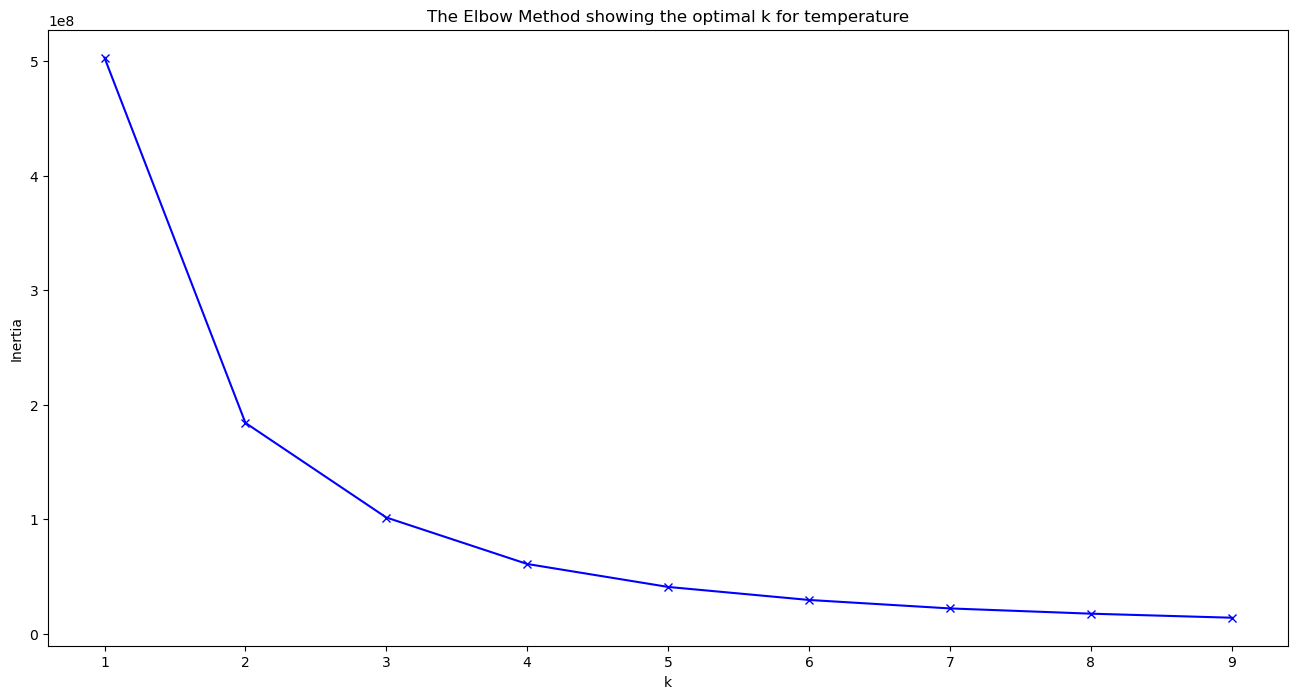

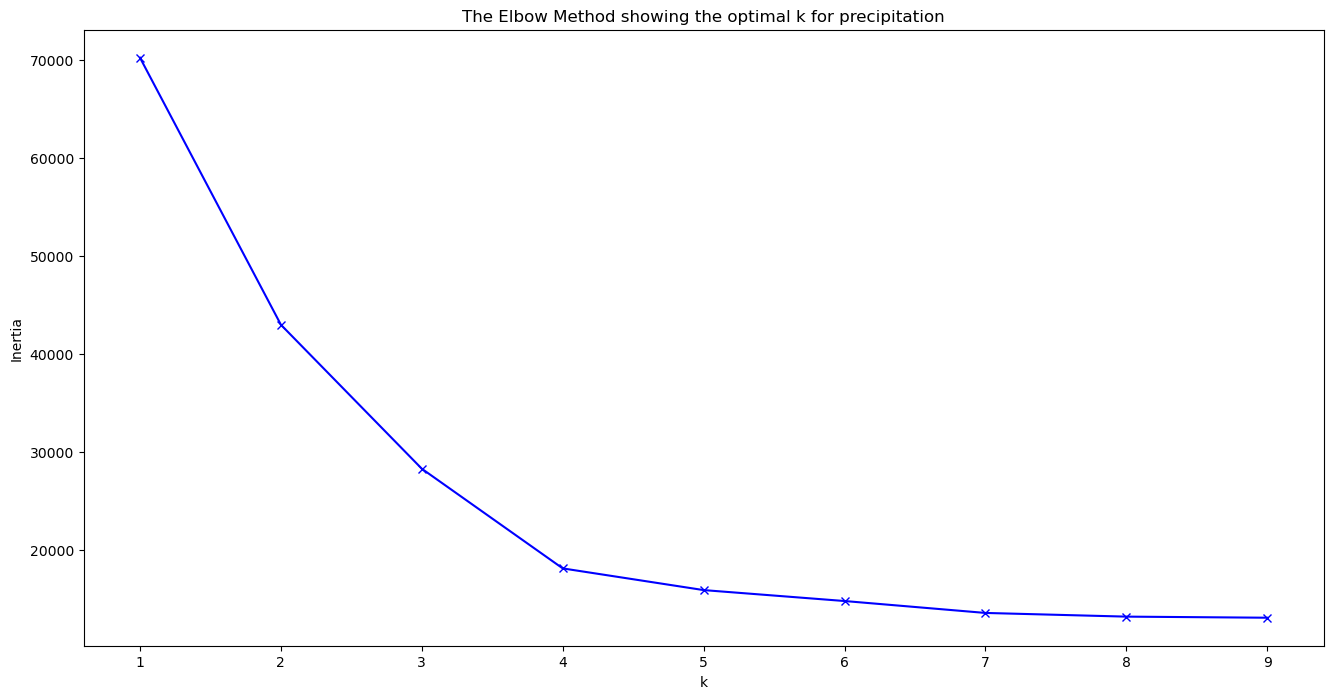

In [18]:
# Let's plot this for our temperature data:

import matplotlib.pyplot as plt

inertia = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_kmeans_temp)
    kmeanModel.fit(df_kmeans_temp)
    inertia.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k for temperature')
plt.show()

# We repeat the same for our precipitation data:

inertia = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_kmeans_precip)
    kmeanModel.fit(df_kmeans_precip)
    inertia.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k for precipitation')
plt.show()

By inspecting the plot, the 'elbow' or bend in the plot can be used to choose the optimal number of clusters by selecting the value at the elbow as the number of clusters to use in the final model. This point represents the most optimal value for k (number of clusters). This is where the decrease in the inertia value becomes significantly smaller.

In other words, adding more clusters beyond this point will not explain much more of the variance in our data: we would only be adding complexity to the model without gaining much information. If there is no clear elbow point, other methods may be needed to determine the optimal number of clusters.

Note: UMAP, available in cuML, is a powerful dimensionality reduction algorithm used for visualizing high-dimensional data and uncovering underlying patterns. While UMAP itself is not a dedicated clustering algorithm, its ability to project data into a lower-dimensional space often reveals clustering structures. It is widely used for cluster exploration and analysis, providing valuable insights into the data. Its efficient implementation in cuML enables advanced data analysis and pattern identification for clustering tasks.

## Classification

Classification is one of the primary tasks of machine learning, a form of supervised learning where the aim is to predict the class or category of an instance or object based on its features.

In our weather forecasting context, we will use classification to predict

- the weather conditions (sunny, cloudy, or rainy)
- the wind direction (north, south, east, west) at specific times and locations.



We've chosen the Random Forest algorithm for this task. Random Forest is a powerful and versatile machine learning method that is particularly effective for classification problems. It is an ensemble learning method, where many decision trees are trained and their predictions are aggregated to provide a final result. The advantage of using a Random Forest is its ability to handle a large number of features and provide a measure of feature importance, as well as its robustness to outliers and ability to avoid overfitting.

In [20]:
import cudf
import cuml
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml import train_test_split
from cuml.metrics import accuracy_score

# Load data
df = cudf.read_csv('./NW_data.csv').dropna()


### Data Preprocessing

Before we train our Random Forest model, we need to preprocess our data. Our Meteonet dataset contains a variety of weather-related parameters recorded at different times and locations.

Firstly, we convert the date column to datetime format and extract the hour as it might be a significant factor in determining the weather condition and wind direction. As we will not need the precise date anymore, we drop this column afterwards.

In [21]:
# Convert date column to datetime and extract hour
df['date'] = cudf.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour

Next, we perform some feature engineering to create two new categorical variables from the existing data.
Let's add two new columns `wind_direction` and `weather_condition` based on the `dd` and `precip` columns respectively.

Assume that the `dd` (wind direction) column contains numerical values representing wind direction in degrees (0-360), and we will discretize them into categories (N, E, S, W). Also, I'll assume that precip column can be used to infer weather conditions such as 'sunny', 'cloudy', 'rainy', etc., which we will also discretize into these categories.

For wind_direction, we discretized the `dd` column (which I assumed to be wind direction in degrees) into 4 categories: North (0-90 degrees), East (90-180), South (180-270) and West (270-360).

For weather_condition, we discretized the precip column (which is the amount of precipitation) into 3 categories: `sunny` (no rain), `cloudy` (little rain), and `rainy` (more rain).
Then we converted these categorical columns into numerical labels that the `RandomForestClassifier` can work with using `.cat.codes.`

In [22]:
# Discretize wind direction
df['wind_direction'] = cudf.cut(df['dd'], bins=[-0.1, 90, 180, 270, 360], labels=['N', 'E', 'S', 'W'])

# Discretize weather condition based on precipitation amount
df['weather_condition'] = cudf.cut(df['precip'], bins=[-0.1, 0.1, 1, float('inf')], labels=['sunny', 'cloudy', 'rainy'])

# Drop the original 'date' column
df = df.drop(['date'], axis=1)

Finally, we convert these newly created categorical variables into numerical labels using .cat.codes to make them suitable for use in our Random Forest model.

In [23]:
# Convert 'wind_direction' and 'weather_condition' columns to category
df['wind_direction'] = df['wind_direction'].astype('category').cat.codes
df['weather_condition'] = df['weather_condition'].astype('category').cat.codes

Once our data preprocessing is complete, we're ready to train our model. We define a function, ```train_and_evaluate(target)```, that splits the data into training and test sets, trains the model on the training data, makes predictions on the test data, and then evaluates the model's performance by comparing the predictions to the actual values.

In [24]:
def train_and_evaluate(target):
    # Split into features and target
    X = df.drop(target, axis=1)
    y = df[target]

    # Split the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Define the model
    model = cuRF()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)

    return model

# Train and evaluate models
weather_condition_model = train_and_evaluate('weather_condition')
wind_direction_model = train_and_evaluate('wind_direction')


/home/jayrodge/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Through this method, we can efficiently predict weather conditions and wind direction using cuML's Random Forest Classifier, achieving promising results as displayed by our accuracy scores. These models could form the basis of a real-time weather prediction system, or they could be further enhanced and used in a variety of climate-related research and applications.

### Benchmarking

This section covers the performance of a handful of typical functions used in this notebook, comparing between Pandas (CPU) and cuDF (GPU) with minimum code change with pd(pandas) -> cudf. You can adopt the code below to compare the performance improvement on your local machine.

Test machine information:

- GPU: NVIDIA RTX 8000
- CPU: Intel® Core™ i7-7800X CPU @ 3.50GHz × 12
- RAPIDS: Rapids 23.04 with CUDA 11.8

In [ ]:
import cudf
import cuml
import pandas as pd
import sklearn
from time import time
from timeit import default_timer as timer
from cuml import make_regression, train_test_split
from sklearn.model_selection import train_test_split as sk_train_test_split

# Create an empty DataFrame
performance_comparison = cudf.DataFrame(columns=['Task', 'GPU Time', 'CPU Time', 'GPU Speedup'])

# Function to add a row in the DataFrame
def add_performance(task, gpu_time, cpu_time):
    global performance_comparison
    speedup = cpu_time / gpu_time
    performance_comparison = performance_comparison.append({'Task': task, 'GPU Time': gpu_time, 'CPU Time': cpu_time, 'GPU Speedup': speedup}, ignore_index=True)


#### Classification

In [ ]:
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml import train_test_split as cu_train_test_split
from cuml.metrics import accuracy_score as cu_accuracy_score
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import accuracy_score as sk_accuracy_score


# Load data
start_t = time()
df_gpu = cudf.read_csv('./NW_data.csv').dropna()
read_gpu_time = time() - start_t

start_t = time()
df_cpu = pd.read_csv('./NW_data.csv').dropna()
read_cpu_time = time() - start_t

# Convert date column to datetime and extract hour
start_t = time()
df_gpu['date'] = cudf.to_datetime(df_gpu['date'])
df_gpu['hour'] = df_gpu['date'].dt.hour
convert_gpu_time = time() - start_t

start_t = time()
df_cpu['date'] = pd.to_datetime(df_cpu['date'])
df_cpu['hour'] = df_cpu['date'].dt.hour
convert_cpu_time = time() - start_t

# Discretize wind direction
start_t = time()
df_gpu['wind_direction'] = cudf.cut(df_gpu['dd'], bins=[-0.1, 90, 180, 270, 360], labels=['N', 'E', 'S', 'W'])
discretize_gpu_time = time() - start_t

start_t = time()
df_cpu['wind_direction'] = pd.cut(df_cpu['dd'], bins=[-0.1, 90, 180, 270, 360], labels=['N', 'E', 'S', 'W'])
discretize_cpu_time = time() - start_t


# Drop the original 'date' column
df_gpu = df_gpu.drop(['date'], axis=1)
df_cpu = df_cpu.drop(['date'], axis=1)

# Convert 'wind_direction' and 'weather_condition' columns to category
df_gpu['wind_direction'] = df_gpu['wind_direction'].astype('category').cat.codes
df_cpu['wind_direction'] = df_cpu['wind_direction'].astype('category').cat.codes


def train_and_evaluate_gpu(target, df):
    start_t = time()
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = cu_train_test_split(X, y, test_size=0.2)
    model =cuRF()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = cu_accuracy_score(y_test, predictions)
    return time() - start_t

def train_and_evaluate_cpu(target, df):
    start_t = time()
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2)
    model = skRF()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = sk_accuracy_score(y_test, predictions)
    return time() - start_t

# Train and evaluate models
gpu_time = train_and_evaluate_gpu('wind_direction', df_gpu)
print(f"GPU training time: {gpu_time} seconds")
cpu_time = train_and_evaluate_cpu('wind_direction', df_cpu)
print(f"CPU training time: {cpu_time} seconds")


print(f"Speedup: {cpu_time / gpu_time} times")

# Summarizing pre-processing time
preprocessing_gpu_time = read_gpu_time + convert_gpu_time + discretize_gpu_time
preprocessing_cpu_time = read_cpu_time + convert_cpu_time + discretize_cpu_time

# print(f"Pre-processing GPU time: {preprocessing_gpu_time} seconds")
# print(f"Pre-processing CPU time: {preprocessing_cpu_time} seconds")
# print(f"Pre-processing speedup: {preprocessing_cpu_time / preprocessing_gpu_time} times")

classification_cpu = preprocessing_cpu_time + cpu_time
classification_gpu = preprocessing_gpu_time + gpu_time


add_performance('Classification', classification_gpu, classification_cpu )
print(performance_comparison)

GPU training time: 28.15667176246643 seconds
CPU training time: 1263.7000896930695 seconds
Speedup: 44.88101791127225 times
             Task   GPU Time     CPU Time  GPU Speedup
0  Classification  30.200331  1323.806841    43.834184


/home/jayrodge/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/cudf/core/indexed_frame.py:3446: FutureWarning: The append method is deprecated and will be removed in a future version. Use cudf.concat instead.
  warnings.warn(


In [ ]:
del df_gpu, df_cpu, gpu_time, cpu_time, cuRF, preprocessing_cpu_time, preprocessing_gpu_time, cu_accuracy_score, skRF, sk_accuracy_score, classification_cpu, classification_gpu


#### Regression

In [ ]:
from cuml import make_regression, train_test_split
from cuml.linear_model import LinearRegression as cuLinearRegression
from cuml.metrics.regression import r2_score
from cuml.preprocessing.LabelEncoder import LabelEncoder
from sklearn.linear_model import LinearRegression as skLinearRegression
from sklearn.model_selection import train_test_split as sk_train_test_split

def train_and_evaluate_cpu(target, df):
    start_t = time()
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2)
    model = skLinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = sk_r2_score(y_test, predictions)
    return time() - start_t, r2

# Load data
start_t = time()
df_gpu = cudf.read_csv('./NW_data.csv').dropna()
read_gpu_time = time() - start_t

start_t = time()
df_cpu = pd.read_csv('./NW_data.csv').dropna()
read_cpu_time = time() - start_t

# Convert categorical variables to numeric variables
start_t = time()
le = LabelEncoder()
df_gpu['number_sta'] = le.fit_transform(df_gpu['number_sta'])
encode_gpu_time = time() - start_t

start_t = time()
df_cpu['number_sta'] = pd.Categorical(df_cpu['number_sta']).codes
encode_cpu_time = time() - start_t

# Normalize numeric features
numeric_columns = ['lat', 'lon', 'height_sta', 'dd', 'ff', 'hu', 'td', 't', 'psl']
start_t = time()
for col in numeric_columns:
    df_gpu[col] = (df_gpu[col] - df_gpu[col].mean()) / df_gpu[col].std()
normalize_gpu_time = time() - start_t

start_t = time()
for col in numeric_columns:
    df_cpu[col] = (df_cpu[col] - df_cpu[col].mean()) / df_cpu[col].std()
normalize_cpu_time = time() - start_t

# Convert date column to datetime and extract hour
start_t = time()
df_gpu['date'] = cudf.to_datetime(df_gpu['date'])
df_gpu['hour'] = df_gpu['date'].dt.hour
df_gpu = df_gpu.drop(['date'], axis=1)
convert_gpu_time = time() - start_t

start_t = time()
df_cpu['date'] = pd.to_datetime(df_cpu['date'])
df_cpu['hour'] = df_cpu['date'].dt.hour
df_cpu = df_cpu.drop(['date'], axis=1)
convert_cpu_time = time() - start_t

def train_and_evaluate_gpu(target, df):
    start_t = time()
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = cuLinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    return time() - start_t, r2

def train_and_evaluate_cpu(target, df):
    start_t = time()
    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2)
    model = skLinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    return time() - start_t, r2

# Train and evaluate models
gpu_time_t, r2_t = train_and_evaluate_gpu('t', df_gpu)
cpu_time_t, r2_t = train_and_evaluate_cpu('t', df_cpu)

preprocessing_gpu_time = read_gpu_time + encode_gpu_time + normalize_gpu_time + convert_gpu_time
preprocessing_cpu_time = read_cpu_time + encode_cpu_time + normalize_cpu_time + convert_cpu_time

regression_time_gpu = preprocessing_gpu_time+gpu_time_t
regression_time_cpu = preprocessing_cpu_time+cpu_time_t

add_performance('Regression', regression_time_gpu, regression_time_cpu )


print(performance_comparison)


             Task   GPU Time     CPU Time  GPU Speedup
0  Classification  30.200331  1323.806841    43.834184
1      Regression   2.998712    73.643124    24.558251


/home/jayrodge/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/cudf/core/indexed_frame.py:3446: FutureWarning: The append method is deprecated and will be removed in a future version. Use cudf.concat instead.
  warnings.warn(


In [ ]:
del LabelEncoder, col, convert_cpu_time, convert_gpu_time, cpu_time_t, df_cpu, df_gpu, encode_cpu_time, encode_gpu_time, gpu_time_t, le, make_regression, normalize_cpu_time, normalize_gpu_time, numeric_columns, preprocessing_cpu_time, preprocessing_gpu_time, r2_score, r2_t, read_cpu_time, read_gpu_time, regression_time_cpu, regression_time_gpu, start_t, train_and_evaluate_cpu, train_and_evaluate_gpu


#### Clustering

In [ ]:
import cudf
import pandas as pd
import cuml
from cuml import KMeans as cuKMeans
from sklearn.cluster import KMeans as skKMeans
from time import time
import matplotlib.pyplot as plt

# Load data
start_t = time()
df_gpu = cudf.read_csv('./NW_data.csv').dropna()
read_gpu_time = time() - start_t

start_t = time()
df_cpu = pd.read_csv('./NW_data.csv').dropna()
read_cpu_time = time() - start_t

# Select the features for clustering
features = ['t']
df_kmeans_gpu = df_gpu[features]
df_kmeans_cpu = df_cpu[features]

# Function to train and fit KMeans model (GPU)
def train_and_evaluate_kmeans_gpu(df, n_clusters):
    start_t = time()
    kmeans = cuKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df)
    return time() - start_t, kmeans

# Function to train and fit KMeans model (CPU)
def train_and_evaluate_kmeans_cpu(df, n_clusters):
    start_t = time()
    kmeans = skKMeans(n_clusters=n_clusters, random_state=42, n_init=1)
    kmeans.fit(df)
    return time() - start_t, kmeans

# Train and evaluate models
max_clusters = 10  # Maximum number of clusters to try
inertias_gpu = []
inertias_cpu = []

for n_clusters in range(1, max_clusters + 1):
    # GPU
    gpu_time, kmeans_gpu = train_and_evaluate_kmeans_gpu(df_kmeans_gpu, n_clusters)
    preprocessing_gpu_time = read_gpu_time
    clustering_time_gpu = preprocessing_gpu_time + gpu_time
    inertias_gpu.append(kmeans_gpu.inertia_)

    # CPU
    cpu_time, kmeans_cpu = train_and_evaluate_kmeans_cpu(df_kmeans_cpu, n_clusters)
    preprocessing_cpu_time = read_cpu_time
    clustering_time_cpu = preprocessing_cpu_time + cpu_time
    inertias_cpu.append(kmeans_cpu.inertia_)

# Train and evaluate models with the optimal number of clusters
optimal_clusters = 5  # You can choose the optimal number of clusters based on the elbow curve
gpu_time, kmeans_gpu = train_and_evaluate_kmeans_gpu(df_kmeans_gpu, optimal_clusters)
cpu_time, kmeans_cpu = train_and_evaluate_kmeans_cpu(df_kmeans_cpu, optimal_clusters)

preprocessing_gpu_time = read_gpu_time
preprocessing_cpu_time = read_cpu_time

clustering_time_gpu = preprocessing_gpu_time + gpu_time
clustering_time_cpu = preprocessing_cpu_time + cpu_time

add_performance('Clustering', clustering_time_gpu, clustering_time_cpu)

print(performance_comparison)


             Task   GPU Time     CPU Time  GPU Speedup
0  Classification  30.200331  1323.806841    43.834184
1      Regression   2.998712    73.643124    24.558251
2      Clustering   3.109476    60.727291    19.529753


/home/jayrodge/miniconda3/envs/rapids-23.04/lib/python3.10/site-packages/cudf/core/indexed_frame.py:3446: FutureWarning: The append method is deprecated and will be removed in a future version. Use cudf.concat instead.
  warnings.warn(


### Conclusion

In this notebook, we explored GPU-accelerated data processing using RAPIDS, cuDF, and cuML. We demonstrated various techniques for handling time series weather data and highlighted the performance benefits of GPU computation compared to CPU-only computation.

The notebook showcased the power of GPU-accelerated workflows in terms of data preprocessing with cuDF, and machine learning training with cuML for Classification, Regression, and clustering. By leveraging the parallel processing capabilities of GPUs, we achieved faster execution times and improved performance. Overall, this notebook provided a comprehensive guide to harnessing the efficiency and performance of GPU-accelerated data processing and machine learning.

### Citation

- Gwennaëlle Larvor, Léa Berthomier, Vincent Chabot, Brice Le Pape, Bruno Pradel, Lior Perez. MeteoNet, an open reference weather dataset by METEO FRANCE, 2020 [dataset link](https://www.kaggle.com/datasets/katerpillar/meteonet)